### 风格迁移常用的损失函数由3部分组成：

1. 内容损失使合成图像与内容图像在内容特征上接近；

2. 风格损失使合成图像与风格图像在风格特征上接近；

3. 全变分损失则有助于减少合成图像中的噪点。

### 合成图像是风格迁移过程中唯一需要更新的变量，即风格迁移所需迭代的模型参数
+ 初始化合成图像，例如将其初始化为内容图像
+ 选择一个预训练的卷积神经网络来抽取图像的特征，其中的模型参数在训练中无须更新

In [1]:
import torch
from torch import nn
import torchvision
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import torchvision.transforms as T
from scipy.io import savemat

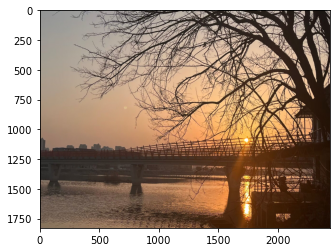

In [9]:
style_img = Image.open(Path('assets')/'view2.jpg')
plt.imshow(style_img)

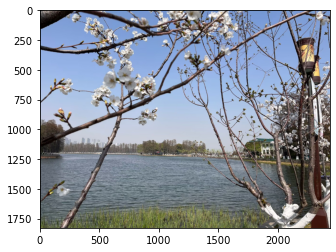

In [11]:
content_img = Image.open(Path('assets')/'view1.jpg')
plt.imshow(content_img)

# 1.预处理和后处理

In [15]:
rgb_mean = torch.tensor([0.485,0.456,0.406]) #RGB三通道的均值（与ImageNet数据集相同）
rgb_std = torch.tensor([0.229,0.224,0.225])

'''
ToTensor将PIL转化为tensor张量（channels,h,w）
'''
def preprocess(img, img_shape):
    transforms = T.Compose([T.Resize(img_shape),T.ToTensor(),
                            T.Normalize(mean=rgb_mean,std=rgb_std)])
    return transforms(img).unsqueeze(0) #增加一维

def postprocess(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1,2,0)*rgb_std + rgb_mean,0,1)#将图片还原
    return T.ToPILImage()(img.permute(2,0,1))

# 2.抽取图像特征

In [21]:
# 基于ImageNet数据集预训练的VGG-19模型来抽取图像特征
pretrain_net = torchvision.models.vgg19(pretrained = True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\Judy_yue/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth


In [24]:
pretrain_net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [25]:
#  为了避免合成图像过多保留内容图像的细节，选择VGG较靠近输出的层，即内容层

#选择每个卷积块的第一个卷积层作为风格层
style_layers, content_layers = [0,5,10,19,28],[25]

#保留需要用到的VGG的所有层
net = nn.Sequential(*[pretrain_net.features[i] 
                      for i in range(max(content_layers+style_layers)+1)])
# 逐层计算，保留内容层和风格层
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in content_layers:
            contents.append(X)
        if i in style_layers:
            styles.append(X)
    return contents,styles

In [26]:
#训练时无须改变预训练的VGG的模型参数，可以在训练开始之前就提取出内容特征和风格特征
#合成图像是风格迁移所需迭代的模型参数

# get_contents函数对内容图像抽取内容特征；
def get_contents(image_shape,device):
    content_X = preprocess(content_img,image_shape).to(device)
    contents_Y,_ = extract_features(content_X, content_layers,style_layers)
    return content_X, contents_Y

# get_styles函数对风格图像抽取风格特征
def get_styles(image_shape,device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y


# 3.定义损失函数
由内容损失、风格损失和全变分损失3部分组成

In [28]:
# 内容损失
def content_loss(Y_hat, Y):
    # 我们从动态计算梯度的树中分离目标：
    # 这是一个规定的值，而不是一个变量。
    return torch.square(Y_hat - Y.detach()).mean()

#风格损失,定义格拉姆矩阵（XX^{T}）
def gram(X):
    num_channels, n = X.shape[1], X.numel()//X.shape[1]
    X = X.reshape((num_channels,n)) ##关注通道风格
    return torch.matmul(X,X.T) / (num_channels * n)

def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

#全变分损失
# 学到的合成图像里面有大量高频噪点,全变分去噪（total variation denoising）
def tv_loss(Y_hat):#使邻近的像素值相似
    return 0.5*(torch.abs(Y_hat[:,:,1:,:] - Y_hat[:,:,:-1,:]).mean()+
               torch.abs(Y_hat[:,:,:,1:] - Y_hat[:,:,:,:-1]).mean())


In [31]:
content_weight, style_weight, tv_weight = 1,1e4,10

def compute_loss(X, contents_Y_hat,styles_Y_hat, contents_Y, style_Y_gram):
    #分别计算内容损失，风格损失，全变分损失
    contents_l = [content_loss(Y_hat,Y)*content_weight 
                 for Y_hat,Y in zip(contents_Y_hat,contents_Y)]
    styles_l = [style_loss(Y_hat,Y)*style_weight
               for Y_hat,Y in zip(styles_Y_hat, style_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    l = sum(styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l


# 4.初始化合成图像
在风格迁移中，合成的图像是训练期间唯一需要更新的变量。因此，可以定义一个简单的模型SynthesizedImage，并将合成的图像视为模型参数

In [30]:
class SynthesizedImage(nn.Module):
    def __init__(self,img_shape,**kwargs):
        super(SynthesizedImage,self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))
        
    def forward(self):
        return self.weight
    
def get_inits(X, device, lr ,styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)#初始化为原始图像
    trainer = torch.optim.Adam(gen_img.parameters(), lr = lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

# 5.训练模型

In [43]:
from d2l import *
%run d2l

In [45]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X,device,lr,styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer,lr_decay_epoch,0.8)
#     animator = Animator(xlabel='epoch', ylabel='loss',
#                             xlim=[10, num_epochs],
#                             legend=['content', 'style', 'TV'],
#                             ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(X, content_layers, style_layers)
        contents_l, styles_l, tv_l,l = compute_loss(X, contents_Y_hat,styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        if (epoch+1) % 10 == 0:
            #plt.imshow(postprocess(X))
#             animator.add(epoch + 1, [float(sum(contents_l)),
#                                      float(sum(styles_l)), float(tv_l)])
            print(f'epoch {epoch+1} contents_loss:{float(sum(contents_l))} \
                  style loss:{float(sum(styles_l))} tv loss:{float(tv_l)}')
    return X

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_shape = (300,450)
net = net.to(device) #截取的VGG网络部分
content_X, contents_Y = get_contents(image_shape,device)
_ ,styles_Y = get_styles(image_shape,device)
lr,num_epochs,lr_decay_epoch = 0.3,500,50
output = train(content_X,contents_Y,styles_Y ,device,lr,num_epochs,lr_decay_epoch)
# filename = 'style_transfer.mat'
# savemat(filename,{'a':output})
plt.imshow(postprocess(output))
plt.savefig('output.jpg')

NameError: name 'net' is not defined